## Workflow to analyze Photometry data

### Imports

In [1]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *

        if you want to export datasets to perform Maching Learning tasks.
        To solve, type pip install sktime in your environment


### Variables

In [2]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

### Tasks
- A tasks definition file (.csv) contains all the information to perform the extractions of behaviorally relevant information from **PyControl** files, for each **task** file. It includes what are the **triggers** of different trial types, what **events** to extract (with time data), and what are events or printed lines that could be relevant to determine the **conditions** (e.g: free reward, optogenetic stimulation type, etc.)
- To analyze a new task you need to append task characteristics like **task** filename, **triggers**, **events** and **conditions**

In [3]:
tasks = pd.read_csv(tasksfile, usecols = [1,2,3,4], index_col = False)
tasks

,task,triggers,events,conditions
0,lick_go_nogo,go; nogo,bar; bar_off; spout,free_reward
1,lick_go_nogo_unconditionned,go; nogo,bar; bar_off; spout,free_reward
2,lick_go_nogo_unconditionned_opto,go; nogo,bar; bar_off; spout,free_reward
3,reaching_go_nogo,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
4,reaching_go_nogo_jc,CS_plus; CS_minus,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
5,reaching_go_nogo_opto_continuous,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset; s_go_sham; s_go_...
6,reaching_go_nogo_opto_sinusoid,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
7,reaching_go_nogo_opto_sinusoid_spout,CS_Go; CS_NoGo,bar; bar_off; spout,s_nogo_sham; s_nogo_cs_onset_2; s_nogo_cs_onse...
8,reaching_go_nogo_reversal,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...
9,reaching_go_nogo_reversal_incentive,CS_Go; CS_NoGo,bar; bar_off; spout,error bar_off; reward bar_off; error free; rew...


### Optional

Transfer Files from hierarchical folders by tasks to flat folders, for photometry and behaviour files

In [ ]:
# photo_root_dir = 'T:\\Data\\head-fixed\\pyphotometry\\data'
# pycontrol_root_dir = 'T:\\Data\\head-fixed\\pycontrol'

# root_folders = [photo_root_dir, pycontrol_root_dir]
# horizontal_folder_pycontrol = 'T:\\Data\\head-fixed\\test_folder\\pycontrol'
# horizontal_folder_photometry = 'T:\\Data\\head-fixed\\test_folder\\photometry'

# copy_files_to_horizontal_folders(root_folders, horizontal_folder_pycontrol, horizontal_folder_photometry)

### Create an experiment object

This will include all the pycontrol files present in the folder_path directory (do not include subdirectories)

In [4]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
# pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')
pycontrol_files_path = r'T:\Data\head-fixed\kms_pycontrol'

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)

# Only use if the Experiment cohort as been processed by trials before
# TODO: assess whether this can be removed or not
exp_cohort.by_trial = True

### Perform extraction of behavioural information by trial

In [ ]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

### Match with photometry, videos, and DeepLabCut files

The following Warning : 

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads...

is due to rsync function for photometry-pycontrol alignment


In [ ]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()


### Define conditions and groups for extraction

In [21]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True, 'reward free': False, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict5 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

Example in progress for Cued-Uncued

In [25]:
# List of uncued conditions as listed on the tasks .csv file for task reaching_go_spout_cued_uncued:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'trigger': 'cued', 'valid': True, 'reward spout cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict1 = {'trigger': 'cued', 'valid': True, 'reward bar cued': True, 'free_reward_timer': False, 'success': True}
conditions_dict2 = {'trigger': 'cued', 'valid': True, 'success': False}
conditions_dict3 = {'trigger': 'uncued', 'valid': True, 'reward free_uncued': True}
conditions_dict4 = {'trigger': 'uncued', 'valid': True, 'reward spout uncued': True, 'free_reward_timer': False, 'success': True}
conditions_dict5 = {'trigger': 'uncued', 'valid': True, 'reward bar uncued': True, 'free_reward_timer': False, 'success': True}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1, conditions_dict2, conditions_dict3, \
    conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Cued spout hit', 'Cued bar hit', 'Cued miss', \
    'Uncued miss', 'Uncued spout hit', 'Uncued bar hit']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 4000]

Example in progress Pavlovian

In [28]:
# List of uncued conditions as listed on the tasks .csv file for task pavlovian_nobar_nodelay:
# free_reward_timer; reward spout cued; reward bar cued; reward bar_off; reward spout uncued; reward bar uncued; reward free; reward free_uncued

# Many combinations possible
conditions_dict0 = {'success': True}
conditions_dict1 = {'success': False}


# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict0, conditions_dict1]
# Aliases for conditions
cond_aliases = ['hit', 'miss']
# Groups as a list of lists
groups = None

# right_handed = [281]
# groups = [[280, 282, 299, 300, 301],\
#     [284, 285, 296, 297, 306, 307]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Extract Photometry trials and create a Continuous_Dataset

In [36]:
cont_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_spout_cued_uncued', #'reaching_go_nogo',
        trig_on_ev = 'spout', # align to the first event of a kind e.g. bar_off
        high_pass = None, 
        low_pass = 30, 
        median_filt = 15,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 10, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f'], 
        remove_artifacts = True,
        verbose = True) # will plot all the process of remove_artifacts if remove_artifacts == True

cont_dataset.set_trial_window(trial_window, 'ms')


No trial in any condition for subject 49 at: 2022-08-10 16:23:41
No trial in any condition for subject 49 at: 2022-08-22 11:07:10
No trial in any condition for subject 51 at: 2022-08-10 17:23:41
No trial in any condition for subject 51 at: 2022-08-22 11:47:40
No trial in any condition for subject 53 at: 2022-08-10 18:16:39
No trial in any condition for subject 53 at: 2022-08-22 11:49:22


In [12]:
cont_dataset.conditions

[{'success': True}, {'success': False}]

### Save Photometry Dataset

In [37]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs'
cont_dataset.save(folder_path, 'photo_kms_reaching_go_spout_cued_uncued_mf15_lp30_spout')

Dataset saved in C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_kms_reaching_go_spout_cued_uncued_mf15_lp30_spout.pkl
data size is 96.37464904785156 Mb


### Reload a pre-existing dataset

In [5]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Cluster trials to exclude artifacts

In [ ]:
cont_dataset.cluster_trials()

### Plot the different clusters of trials

In [ ]:
cont_dataset.plot_clustered_trials()

### Optional methods

In [38]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filterout_conditions([])

# exclude some groups by IDs
cont_dataset.filterout_groups([])

# exclude some subjects
cont_dataset.filterout_subjects([0,1, 52])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 7)

# Keep only last n sessions
cont_dataset.filter_lastNsessions(n = 3)

# Filter artifacted trials
cont_dataset.filterout_clusters([-1, 1, 2]) # Good cluster is classically 0

# Exclude sessions by dates
# cont_dataset.filterout_dates(days_to_exclude = )

# To remove subjects who do not have
# trials in all the conditions
# Careful when using on sessions when not all conditions are present, 
# it could exclude a big number of whole sessions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

cond_ID: 0, group_idx 0, subj 47
cond_ID: 0, group_idx 0, subj 48
cond_ID: 0, group_idx 0, subj 49
cond_ID: 0, group_idx 0, subj 50
cond_ID: 0, group_idx 0, subj 51
cond_ID: 0, group_idx 0, subj 53
cond_ID: 1, group_idx 0, subj 47
cond_ID: 1, group_idx 0, subj 48
cond_ID: 1, group_idx 0, subj 49
cond_ID: 1, group_idx 0, subj 50
cond_ID: 1, group_idx 0, subj 51
cond_ID: 1, group_idx 0, subj 53
cond_ID: 2, group_idx 0, subj 47
cond_ID: 2, group_idx 0, subj 48
cond_ID: 2, group_idx 0, subj 49
cond_ID: 2, group_idx 0, subj 50
cond_ID: 2, group_idx 0, subj 51
cond_ID: 2, group_idx 0, subj 53
cond_ID: 3, group_idx 0, subj 47
cond_ID: 3, group_idx 0, subj 49
cond_ID: 3, group_idx 0, subj 50
cond_ID: 3, group_idx 0, subj 51
cond_ID: 3, group_idx 0, subj 53
cond_ID: 4, group_idx 0, subj 47
cond_ID: 4, group_idx 0, subj 49
cond_ID: 4, group_idx 0, subj 50
cond_ID: 4, group_idx 0, subj 51
cond_ID: 4, group_idx 0, subj 53
cond_ID: 5, group_idx 0, subj 47
cond_ID: 5, group_idx 0, subj 49
cond_ID: 5

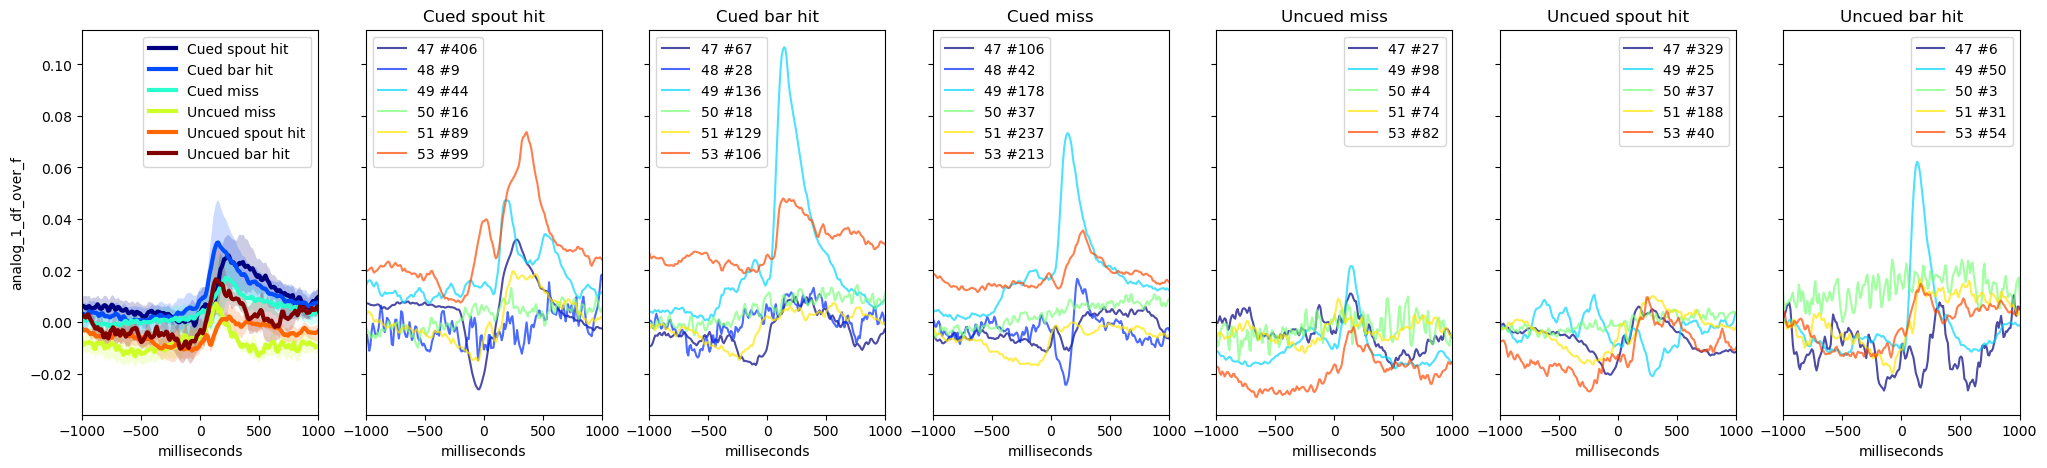

True     3008
False     150
Name: keep, dtype: int64

In [41]:
# if this was not set at creation
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-1000, 1000],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (25, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



In [87]:
cont_dataset.get_groups()

array([array([280, 282, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300,
              301, 303, 304, 305, 306, 307], dtype=int64)                     ],
      dtype=object)

### Optional methods

In [303]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


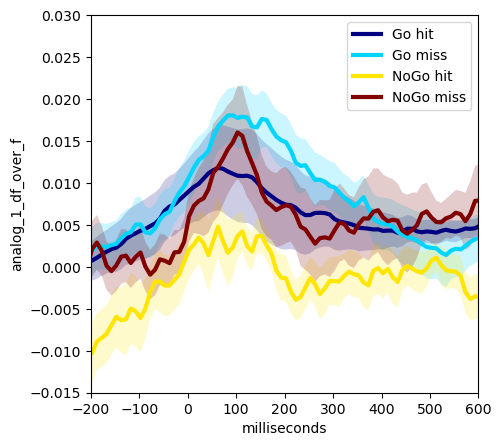

In [304]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)


In [305]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [306]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


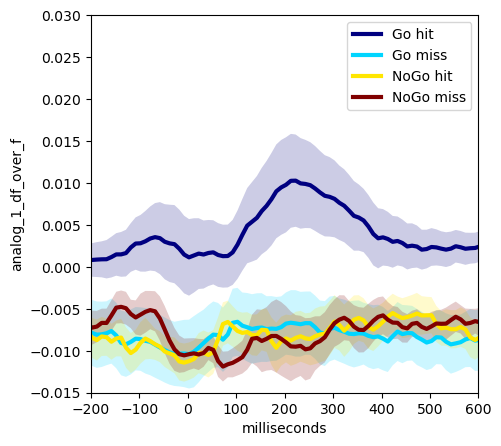

In [307]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)
